In [1]:
import wandb
import datetime
from argparse import Namespace
wandb.login()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s0221824 (312704006). Use `wandb login --relogin` to force relogin


True

In [2]:
import numpy as np
import pandas as pd
import random


# model interpretability
from captum.attr import IntegratedGradients

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transform
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image, ImageFile
import copy
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

/home/server4090-3/anaconda3/envs/yuhan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)

    # Set NumPy random seed
    np.random.seed(seed)

    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(42)

In [4]:
config=Namespace(
    project_name="3DCNN_TRANSFORMER_ENSEMBLE",
    batch_size = 16,
    epochs = 150,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    criterion = nn.CrossEntropyLoss()
    )
    
print(config.device)

cuda


In [5]:
# root_dir="./data/Thermal Camera Images" #480x640
# file=[]
# label=["NoGas","Perfume","Smoke","Mixture"]
# for i,cls in enumerate(label):
#     class_dir = os.path.join(root_dir, cls)
#     class_image=[f for f in os.listdir(class_dir)]
#     for img in class_image:
#         file.append((os.path.join(class_dir, img), i))

# file=np.array(file)
# # print(file)

In [6]:
root_dir="../data/Thermal Camera Images" #480x640 "..":表上級目錄
file=[]
label=["NoGas","Perfume","Smoke","Mixture"]

for i, cls in enumerate(label):
    # print(cls)
    class_dir = os.path.join(root_dir, cls)
    class_image=[f for f in os.listdir(class_dir)]
    class_image = sorted(class_image, key=lambda x: int(x.split("_")[0]))
    for img in class_image:
        file.append((os.path.join(class_dir, img), i))

file = np.array(file)

print(file)

[['../data/Thermal Camera Images/NoGas/0_NoGas.png' '0']
 ['../data/Thermal Camera Images/NoGas/1_NoGas.png' '0']
 ['../data/Thermal Camera Images/NoGas/2_NoGas.png' '0']
 ...
 ['../data/Thermal Camera Images/Mixture/1597_Mixture.png' '3']
 ['../data/Thermal Camera Images/Mixture/1598_Mixture.png' '3']
 ['../data/Thermal Camera Images/Mixture/1599_Mixture.png' '3']]


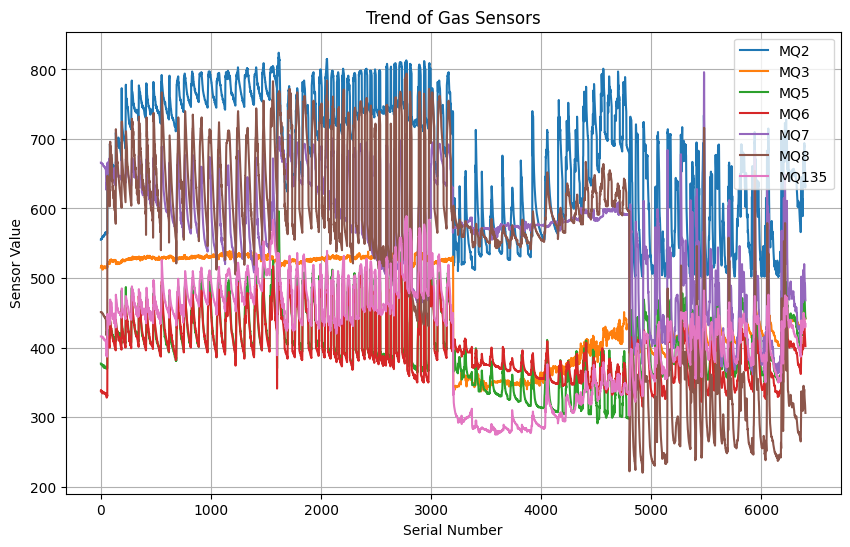

In [7]:
df=pd.read_csv("../data/Gas Sensors Measurements/Gas_Sensors_Measurements.csv")

# 繪製趨勢圖
plt.figure(figsize=(10, 6))
for column in df.columns[1:8]:  # 選擇MQ2到MQ135列
    plt.plot(df[column], label=column)

plt.xlabel('Serial Number')
plt.ylabel('Sensor Value')
plt.title('Trend of Gas Sensors')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# data=pd.read_csv("./data/Gas Sensors Measurements/Gas_Sensors_Measurements.csv")
# data=data.drop("Corresponding Image Name",axis=1)
# data=data.drop("Gas",axis=1)
# # data=data.drop("Serial Number",axis=1)
# # data.insert(1,"index", range(0, len(data))) #新增feature 1-6400


# data_cat=np.concatenate((data, file), axis=1)
# scaler = MinMaxScaler(feature_range=(0,1))
# data_cat[:,1:8]=scaler.fit_transform(data_cat[:,1:8]) # feature 1 (1-1600)*4|feature 2 1-6400|feature 3-9 sensor
# # print(data_cat)

# train_data=[]
# valid_data=[]
# test_data=[]

# for i in range(4):
#     total_samples = 1600
#     train_samples = int(total_samples * 0.6)
#     val_samples = int(total_samples * 0.2)
#     test_samples = total_samples - train_samples - val_samples
    
#     train_data.extend(data_cat[total_samples*i:total_samples*i+train_samples])
#     valid_data.extend(data_cat[total_samples*i+train_samples:total_samples*i+train_samples+val_samples])
#     test_data.extend(data_cat[total_samples*i+train_samples+val_samples:1600*(i+1)])
    
# train_data = np.array(train_data)
# valid_data = np.array(valid_data)
# test_data = np.array(test_data)
# print(len(train_data),len(valid_data),len(test_data))

# # indices = [i for i in range(len(data_cat)) if i%5!=0]
# # train_=data_cat[indices] #5120
# # # print(train_)
# # indices_tr=[i for i in indices if i%6!=0]
# # # print(indices_vl)
# # train_id=train_[:,1].astype(int)
# # train=train_[np.isin(train_id,indices_tr)]
# # indices_vl=[i for i in indices if i%6==0]
# # valid=train_[np.isin(train_id,indices_vl)]
# # indices = [i for i in range(len(data_cat)) if i%5==0]
# # test=data_cat[indices]
# # print(len(train),len(valid),len(test))

# y_train=train_data[:,-1]
# MQ_train=train_data[:,1:8]
# image_train=train_data[:,-2]

# y_valid=valid_data[:,-1]
# MQ_valid=valid_data[:,1:8]
# image_valid=valid_data[:,-2]

# y_test=test_data[:,-1]
# MQ_test=test_data[:,1:8]
# image_test=test_data[:,-2]

In [9]:
data=pd.read_csv("../data/Gas Sensors Measurements/Gas_Sensors_Measurements.csv")
data=data.drop("Corresponding Image Name",axis=1)
data=data.drop("Gas",axis=1)
# data=data.drop("Serial Number",axis=1)
data.insert(1,"index", range(0, len(data))) #新增feature 1-6400
data=np.array(data)

data_cat=np.concatenate((data, file), axis=1)
scaler = MinMaxScaler(feature_range=(0,1))
data_cat[:,2:9]=scaler.fit_transform(data[:,2:9]) # feature 1 (1-1600)*4|feature 2 1-6400|feature 3-9 sensor
print(data_cat)
# train_ratio = 0.6
# valid_ratio = 0.2
# test_ratio = 0.2

# # 計算相應的樣本數量
# total_samples = len(data_cat)
# num_train = int(train_ratio * total_samples)
# num_valid = int(valid_ratio * total_samples)

# # 使用 numpy 的切片功能進行分割
# train, X_temp= data_cat[:num_train], data_cat[num_train:num_train + num_valid]
# valid, test= data_cat[num_train:num_train + num_valid], data_cat[num_train + num_valid:]

indices = [i for i in range(len(data_cat)) if i%5!=0]
train_=data_cat[indices] #5120
# print(train_)
indices_tr=[i for i in indices if i%6!=0]
# print(indices_vl)
train_id=train_[:,1].astype(int)
train=train_[np.isin(train_id,indices_tr)]
indices_vl=[i for i in indices if i%6==0]
valid=train_[np.isin(train_id,indices_vl)]
indices = [i for i in range(len(data_cat)) if i%5==0]
test=data_cat[indices]
print(len(train),len(valid),len(test))
# train_,test=train_test_split(data_cat,train_size=0.8,random_state=42)
# train,valid=train_test_split(train_,train_size=0.8,random_state=42)

# sorted_indices_tr = np.argsort(train[:, 0])
# sorted_indices_vl = np.argsort(valid[:, 0])
# sorted_indices_tt = np.argsort(test[:, 0])
# train=train[sorted_indices_tr]
# valid=train[sorted_indices_vl]
# test=train[sorted_indices_tt]

y_train=train[:,-1]
# print(y_train)
MQ_train=train[:,2:9]

image_train=train[:,-2]
print(image_train)
y_valid=valid[:,-1]
MQ_valid=valid[:,2:9]
image_valid=valid[:,-2]

y_test=test[:,-1]
MQ_test=test[:,2:9]
image_test=test[:,-2]

[['0' '0' '0.1645962732919255' ... '0.44904458598726127'
  '../data/Thermal Camera Images/NoGas/0_NoGas.png' '0']
 ['1' '1' '0.1645962732919255' ... '0.44904458598726127'
  '../data/Thermal Camera Images/NoGas/1_NoGas.png' '0']
 ['2' '2' '0.16770186335403725' ... '0.44904458598726127'
  '../data/Thermal Camera Images/NoGas/2_NoGas.png' '0']
 ...
 ['1597' '6397' '0.3975155279503104' ... '0.49044585987261147'
  '../data/Thermal Camera Images/Mixture/1597_Mixture.png' '3']
 ['1598' '6398' '0.40372670807453415' ... '0.49363057324840776'
  '../data/Thermal Camera Images/Mixture/1598_Mixture.png' '3']
 ['1599' '6399' '0.4068322981366459' ... '0.5063694267515925'
  '../data/Thermal Camera Images/Mixture/1599_Mixture.png' '3']]
4267 853 1280
['../data/Thermal Camera Images/NoGas/1_NoGas.png'
 '../data/Thermal Camera Images/NoGas/2_NoGas.png'
 '../data/Thermal Camera Images/NoGas/3_NoGas.png' ...
 '../data/Thermal Camera Images/Mixture/1597_Mixture.png'
 '../data/Thermal Camera Images/Mixture/1

In [10]:
class sensordata(nn.Module):
    def __init__(self,target,MQ=None,image=None,transform=None,seq_len=12):
        self.seq_len=seq_len
        self.transform=transform
        self.img = image

        self.MQ=MQ
        self.target = target
        self.transform = transform

    def __len__(self):

        return len(self.target)-self.seq_len
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        while len(set(self.target[idx:idx+self.seq_len]))>1: #如果取到的時間序列含有2個label
            idx+=1 

        target = self.target[idx].astype(np.int64)

        # target=torch.Tensor(target)
        if self.img is not None:
            img_name =[]
            
            # for i in range(12):
            #     print("Sequence:", img_name[i])
            # print(img_name)
            # img_name=Image.fromarray(img_name)
            for i in range(idx,(idx+self.seq_len)):
                image=Image.open(self.img[i])
                
                if self.transform:
                    image = self.transform(image)
                
                img_name.append(image)
            img_name=torch.stack(img_name)
            # print(img_name)
            # image = image.permute(2,1,0)#.long()
            # print("First batch of image data:")
            # for i in range(12):
            #     print("Sequence:", image[i])
            
            if self.MQ is None:
                return img_name,target
        if self.MQ is not None:
            MQ_name = self.MQ[idx:idx+self.seq_len].astype(float)

            # target=torch.Tensor(target)
            # print("First batch of sensor data:")
            # for i in range(12):
            #     print("Sequence:", MQ_name[i])
            #     print()
            # print(MQ_name.shape) #(12,7)
            # print(target)
            # print(target)
            # print(MQ_name.shape)
            MQ_idx = torch.FloatTensor(MQ_name)
            # print(MQ_idx.size())
            if self.img is None:
                return MQ_idx,target

        return MQ_idx,img_name,target
train_transform = transforms.Compose([
    transforms.Resize((56,56)),
    transforms.RandomHorizontalFlip(), #這個不會讓圖片增加2倍，0.5的機率圖片翻轉
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((56,56)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
tr_data_all=sensordata(y_train,MQ=MQ_train,image=image_train,transform=train_transform)
vl_data_all=sensordata(y_valid,MQ_valid,image_valid,transform=test_transform)
tt_data_all=sensordata(y_test,MQ=MQ_test,image=image_test,transform=test_transform)

tr_loader_all = DataLoader(tr_data_all, shuffle=True, batch_size=config.batch_size)
vl_loader_all = DataLoader(vl_data_all, shuffle=False, batch_size=config.batch_size)
tt_loader_all=DataLoader(tt_data_all,shuffle=False, batch_size=config.batch_size)
sensor,img ,labels= next(iter(tr_loader_all))
print(sensor.shape)
print(img.shape)
print(labels)


torch.Size([16, 12, 7])
torch.Size([16, 12, 3, 56, 56])
tensor([3, 0, 0, 1, 2, 0, 3, 0, 0, 0, 1, 0, 3, 0, 0, 0])


## image
### model

In [12]:
# # weights = VGG19_BN_Weights.IMAGENET1K_V1
# model_ft = vgg19_bn(weights=None,progress=True)
# classifier = list(model_ft.classifier.children())
# classifier[-1] = nn.Linear(4096, 4)
# model_ft.classifier = nn.Sequential(*classifier)
# model_ft = model_ft.to(config.device)



In [13]:
# 3DCNN
class SimplifiedVGG19_3D(nn.Module):
    def __init__(self, num_classes):
        super(SimplifiedVGG19_3D, self).__init__()
        self.features = nn.Sequential(
            nn.Conv3d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),
            # nn.Conv3d(32, 64, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            # nn.MaxPool3d(kernel_size=2, stride=2),
            # nn.Conv3d(64, 128, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            # nn.MaxPool3d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool3d((1, 4, 4))
        self.classifier = nn.Sequential(
            nn.Linear(32*4*4 , 64),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# 創建簡化版的模型
num_classes = 4  # 用於示範，請根據您的任務修改類別數量
model_ft = SimplifiedVGG19_3D(num_classes).to(config.device)

In [14]:
from torchsummary import summary
summary(model_ft,(3,12,56,56))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 12, 56, 56]           2,624
              ReLU-2       [-1, 32, 12, 56, 56]               0
         MaxPool3d-3        [-1, 32, 6, 28, 28]               0
 AdaptiveAvgPool3d-4          [-1, 32, 1, 4, 4]               0
            Linear-5                   [-1, 64]          32,832
              ReLU-6                   [-1, 64]               0
           Dropout-7                   [-1, 64]               0
            Linear-8                    [-1, 4]             260
Total params: 35,716
Trainable params: 35,716
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.43
Forward/backward pass size (MB): 19.53
Params size (MB): 0.14
Estimated Total Size (MB): 20.10
----------------------------------------------------------------


In [15]:
# # 定義修改後的 3D VGG19
# class ModifiedVGG19_3D(nn.Module):
#     def __init__(self, num_classes):
#         super(ModifiedVGG19_3D, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv3d(3, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1)),
#             nn.ReLU(inplace=True),
#             nn.Conv3d(64, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1)),
#             nn.ReLU(inplace=True),
#             nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),
#             # 添加更多卷積層和池化層以適應較小的深度
#             # 這裡是一個示例，您可能需要根據您的任務進行調整
#             nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1)),
#             nn.ReLU(inplace=True),
#             nn.Conv3d(128, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1)),
#             nn.ReLU(inplace=True),
#             nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),
#         )
#         self.avgpool = nn.AdaptiveAvgPool3d((2, 7, 7))
#         self.classifier = nn.Sequential(
#             nn.Linear(128 * 2 * 7 * 7, 512),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(512, 512),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(512, num_classes),
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         # x = nn.functional.normalize(x, p=2, dim=1)
#         x = self.classifier(x)
#         return x

# # 創建修改後的模型
# num_classes = 4 # 用於示範，請根據您的任務修改類別數量
# model_ft = ModifiedVGG19_3D(num_classes).to(config.device)


## MQsensor

### model

In [16]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000): #d_model:embedding size
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) #(5000,1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term) #越後面的dim頻率越小 sin填入偶數行
        pe[:, 1::2] = torch.cos(position * div_term) #cos填入奇數行
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :] #x是time series不用另外embedding
        return self.dropout(x)

In [17]:
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=7, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model) #(16,12,64)
        self.pos_encoder = PositionalEncoding(d_model, dropout) #(16,12,64)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 4)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x) #16,12,64
        x = self.decoder(x[:, -1, :]) #seq_len的最後一步 #16,4
        # print(x.size())
        return x


In [18]:
transformmodel = TransformerModel().to(config.device)

## lstm shap


In [19]:
# for average feature important
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(10,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
        plt.show()

In [20]:
# batch = next(iter(vl_loader_all))
# data,img, target = batch
# data=data.to(config.device)
# feature_names=["MQ2","MQ3","MQ5","MQ6","MQ7","MQ8","MQ135"]

# ig = IntegratedGradients(transformmodel)
# data.requires_grad_()
# attr, delta = ig.attribute(data,target=0,return_convergence_delta=True,n_steps=12, internal_batch_size=config.batch_size)

# attr = attr.detach().cpu().numpy()
# print(attr.shape)

# visualize_importances(feature_names, np.mean(np.mean(attr,axis=0), axis=0))

## multimodal

In [21]:
class CombinedFCModel(nn.Module):
    def __init__(self,
                 model_dim=8,
                 drop_and_BN='drop-BN',
                 num_labels=4,
                 dropout=0.2):

        super(CombinedFCModel, self).__init__()

        self.model_dim = model_dim
        # self.drop_and_BN = drop_and_BN

        # self.dropout = nn.Dropout(dropout)

        #sequence
        self.transformer=transformmodel
        # self.bn_sequence = nn.BatchNorm1d(model_dim)

        #image
        self.vgg=model_ft
        # self.bn_vgg = nn.BatchNorm1d(model_dim)

        #classifier
        self.linear1 = nn.Linear(model_dim, 16)
        # self.bn_1 = nn.BatchNorm1d(16)
        self.linear2 = nn.Linear(16, num_labels)
        self.softmax = nn.Softmax(dim=1)

    # def drop_BN_layer(self, x, part='seq'):
    #     if part == 'seq':
    #         bn = self.bn_sequence
    #     elif part == 'vgg':
    #         bn = self.bn_vgg

    #     if self.drop_and_BN == 'drop-BN':
    #         x = self.dropout(x)
    #         x = bn(x)
    #     elif self.drop_and_BN == 'BN-drop':
    #         x = bn(x)
    #         x = self.dropout(x)
    #     elif self.drop_and_BN == 'drop-only':
    #         x = self.dropout(x)
    #     elif self.drop_and_BN == 'BN-only':
    #         x = bn(x)
    #     elif self.drop_and_BN == 'none':
    #         pass

    #     return x

    def forward(self, image,sensor):


        #visual feature
        
        image=image.transpose(1, 2)
        # print(image.size())
        output = self.vgg(image)
        # output = F.relu(self.linear_image(output))
        # output = self.drop_BN_layer(output, part='vgg')


        #sequence
        se_out=self.transformer(sensor)
        # print(se_out.size())
        # se_out=self.drop_BN_layer(se_out,part="seq")

        output = torch.cat([output, se_out], dim=1)
        

        output = torch.relu(self.linear1(output))
        # output = self.dropout(output)
        # output = self.bn_1(output)
        output = self.linear2(output)  #(16,4)
        # print('output_size:{}'.format(output.shape))
        y_pred_prob = self.softmax(output)

        return output, y_pred_prob

In [22]:
combined_model = CombinedFCModel().to(config.device)

In [23]:
combined_model

CombinedFCModel(
  (transformer): TransformerModel(
    (encoder): Linear(in_features=7, out_features=64, bias=True)
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): Linear(in_features=64, out_feat

In [24]:
class BaggingEnsemble(nn.Module):
    def __init__(self, base_model_class, num_models, *args, **kwargs):
        super(BaggingEnsemble, self).__init__()
        self.models = nn.ModuleList([base_model_class(*args, **kwargs) for _ in range(num_models)])
        self.num_models = num_models

    def forward(self, image, sensor):
        outputs = []
        y_pred_probs = []
        for model in self.models:
            output, y_pred_prob = model(image, sensor)
            outputs.append(output)
            y_pred_probs.append(y_pred_prob)

        # Average predictions
        avg_output = torch.mean(torch.stack(outputs), dim=0)
        avg_y_pred_prob = torch.mean(torch.stack(y_pred_probs), dim=0)

        return avg_output, avg_y_pred_prob


In [25]:
ensemble_model = BaggingEnsemble(CombinedFCModel, num_models=5, model_dim=8, num_labels=4, dropout=0.2).to(config.device)

In [26]:
ensemble_model.models[0].transformer

TransformerModel(
  (encoder): Linear(in_features=7, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=64, out_features=4, bias=True)
)

In [27]:
def train_combined(model,train_loader,device, optimizer, loss_fn):
    model.train()

    n_corrects = 0
    total = 0
    train_loss = 0.
    step = 0
    for idx, (sensor_data,img_data,label) in enumerate(train_loader): ##有266個batch每個batch size=16
        img_data= img_data.to(device)
        print(idx)
        sensor_data=sensor_data.to(device)
        labels=label.to(device)
        optimizer.zero_grad()

        output_combined = model(img_data,sensor_data)
        loss_combined = loss_fn(output_combined[0], labels) 

        _, predictions = torch.max(output_combined[1], dim=1) #softmax後
        n_corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        train_loss += loss_combined.item()


        loss_combined.backward()
        optimizer.step()

        current_lr = optimizer.param_groups[0]["lr"]
        step += 1

        train_accuracy = 100. * n_corrects/total

        avg_train_loss = train_loss/(idx+1)
        if (idx+1) % 16 == 0:
            print(f'Batch: [{idx+1}/{len(train_loader)}], Training Loss: {avg_train_loss:.3f} | Training Acc: {train_accuracy:.2f}% | lr: {current_lr:.5f}')

    avg_train_loss = train_loss/(step+1)
    train_accuracy = 100. * n_corrects/total
    return avg_train_loss, train_accuracy

def valid_combined(model,valid_loader,device, loss_fn):
    model.eval()


    n_corrects = 0
    total = 0
    valid_loss = 0.
    for idx, (sensor_data,img_data,label) in enumerate(valid_loader):
        with torch.no_grad():
            img_data= img_data.to(device)
            sensor_data=sensor_data.to(device)
            labels=label.to(device)


        output_combined = model(img_data,sensor_data)
        loss_combined = loss_fn(output_combined[0], labels)
        _, predictions = torch.max(output_combined[1], dim=1)
        n_corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        valid_loss += loss_combined.item()
        idx += 1
    avg_valid_loss = valid_loss/(idx+1)
    valid_accuracy = 100 * n_corrects/total
    return avg_valid_loss, valid_accuracy,model
def test_combined(model, test_loader, device):
    model.eval()

    n_corrects = 0
    total = 0
    all_predictions = []
    all_labels = []

    for idx, (sensor_data, img_data, label) in enumerate(test_loader):

        with torch.no_grad():
            img_data = img_data.to(device)
            sensor_data = sensor_data.to(device)
            labels = label.to(device)

        output_combined = model(img_data, sensor_data)

        _, predictions = torch.max(output_combined[1], dim=1)
        n_corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    valid_accuracy = 100 * n_corrects / total
    # Compute confusion matrix
    confusion_mat = confusion_matrix(all_labels, all_predictions)

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.set(font_scale=1.5)  # Adjust font size
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=range(4), yticklabels=range(4))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Compute precision, recall, and F1 score
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average=None)
    
    return valid_accuracy, confusion_mat, precision, recall, f1_score

from sklearn.metrics import accuracy_score
def evaluate_model(model, test_loader):
    model.eval()
    n_corrects_list = [0] * model.num_models
    total = 0

    with torch.no_grad():
        for sensors,images,labels in test_loader:
            sensors, images = sensors.to(config.device), images.to(config.device)
            labels = labels.to(config.device)
            total += labels.size(0)
            
            for i, single_model in enumerate(model.models):
                output = single_model(images, sensors)
                _, predictions = torch.max(output[1], dim=1)
                n_corrects_list[i] += predictions.eq(labels).sum().item()

    accuracies = []
    for i in range(model.num_models):
        valid_accuracy = 100 * n_corrects_list[i] / total
        accuracies.append(valid_accuracy)
        print(f'Accuracy of model {i + 1}: {valid_accuracy:.2f}%')

    return accuracies

In [28]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss,model):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            torch.save(model.state_dict(), 'models/all_ensemble_model.pth')
            print('Saving model (loss = {:.4f})'
            .format(self.min_validation_loss))
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            print(f"|||early stop:{self.counter}")
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
criterion = nn.CrossEntropyLoss()
# ======multimodal=====
optimizer = optim.SGD(list(model_ft.parameters()) + list(transformmodel.parameters()) +
                      list(ensemble_model.parameters()), lr=0.0005, momentum=0.9)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.5, patience=7, verbose=True)

In [ ]:
# -------------------------
# ---- train model ----
# -------------------------
early_stopper = EarlyStopper(patience=10)
epoch_nums=[]
training_loss=[]
validation_loss=[]

nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
wandb.init(project=config.project_name, config = config.__dict__, name = nowtime, save_code=True)
ensemble_model.run_id = wandb.run.id

for epoch in range(config.epochs):
    
    train_loss, train_accuracy = train_combined(ensemble_model,tr_loader_all, config.device, optimizer, config.criterion)
    valid_loss, valid_accuracy,model= valid_combined(ensemble_model,vl_loader_all, config.device, config.criterion)
    print(f'[{epoch+1}/{config.epochs}] | validation loss: {valid_loss:.4f} | validation accuracy: {valid_accuracy:.2f}%')
    scheduler.step(valid_loss)
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(valid_loss)
    if early_stopper.early_stop(valid_loss,model):
        break
    
    wandb.log({'epoch': epoch, 'train_loss': train_loss, 'valid_loss': valid_loss,"train_acc":train_accuracy,"valid_acc":valid_accuracy})

wandb.finish()


In [ ]:
test_acc, confusion_mat, precision, recall, f1_score= test_combined(ensemble_model,tt_loader_all, config.device)
print(f"test acc:{test_acc:.4f}")

In [29]:
# del combined_model
combined_model =  CombinedFCModel().to(config.device)
ensemble_model = BaggingEnsemble(CombinedFCModel, num_models=5, model_dim=8, num_labels=4, dropout=0.2).to(config.device)
ckpt = torch.load('models/all_ensemble_model.pth', map_location='cpu')  # Load your best model
ensemble_model.load_state_dict(ckpt)
test_acc, confusion_mat, precision, recall, f1_score= test_combined(ensemble_model,tt_loader_all, config.device)
print(f"test acc:{test_acc:.4f}")

In [ ]:
ensemble_model.models

In [ ]:
accuracies=evaluate_model(ensemble_model,tt_loader_all)

In [ ]:
precision, recall, f1_score

In [ ]:
accuracies

In [31]:
sensor_tr,img_tr ,labels_tr= next(iter(tr_loader_all))
sensor,img ,labels= next(iter(tt_loader_all))
print(img.shape)
print(sensor.shape)

torch.Size([16, 12, 3, 56, 56])
torch.Size([16, 12, 7])


In [30]:
def stack_all_batches(loader):
    all_sensor = []
    all_img = []
    all_labels = []
    
    for batch in loader:
        if len(batch) == 3:
            sensor, img, labels = batch
            all_sensor.append(sensor)
            all_img.append(img)
            all_labels.append(labels)
        elif len(batch) == 2:
            if isinstance(batch[0], torch.Tensor):  # Sensor data case
                sensor, labels = batch
                all_sensor.append(sensor)
                all_labels.append(labels)
            else:  # Image data case
                img, labels = batch
                all_img.append(img)
                all_labels.append(labels)
    
    if all_sensor:
        all_sensor = torch.cat(all_sensor, dim=0)
    if all_img:
        all_img = torch.cat(all_img, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    return all_sensor, all_img, all_labels


In [31]:
# Assuming DataLoader and other necessary imports are already done
from torch.utils.data import DataLoader

# Example DataLoader instantiation (as provided by you)
tr_data_all = sensordata(y_train, MQ=MQ_train, image=image_train, transform=train_transform)
vl_data_all = sensordata(y_valid, MQ=MQ_valid, image=image_valid, transform=test_transform)
tt_data_all = sensordata(y_test, MQ=MQ_test, image=image_test, transform=test_transform)

tr_loader_all = DataLoader(tr_data_all, shuffle=True, batch_size=config.batch_size)
vl_loader_all = DataLoader(vl_data_all, shuffle=False, batch_size=config.batch_size)
tt_loader_all = DataLoader(tt_data_all, shuffle=False, batch_size=config.batch_size)

# Stack all batches for training, validation, and testing
train_sensor, train_img, train_labels = stack_all_batches(tr_loader_all)
valid_sensor, valid_img, valid_labels = stack_all_batches(vl_loader_all)
test_sensor, test_img, test_labels = stack_all_batches(tt_loader_all)

# Print shapes
print("Train sensor shape:", train_sensor.shape)
# print("Train image shape:", train_img.shape)
# print("Train labels shape:", train_labels.shape)

print("Valid sensor shape:", valid_sensor.shape)
# print("Valid image shape:", valid_img.shape)
# print("Valid labels shape:", valid_labels.shape)

print("Test sensor shape:", test_sensor.shape)
# print("Test image shape:", test_img.shape)
# print("Test labels shape:", test_labels.shape)


Train sensor shape: torch.Size([4255, 12, 7])
Valid sensor shape: torch.Size([841, 12, 7])
Test sensor shape: torch.Size([1268, 12, 7])


## For train set

In [33]:
import shap
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
# 假設你的 Transformer 模型為 combined_model.transformer
transformer_model = ensemble_model.models[0].transformer
transformer_model=transformer_model.cpu()

explainer = shap.DeepExplainer(transformer_model, valid_sensor)


# 計算 SHAP 值
shap_values = explainer.shap_values(valid_sensor)

# # 手動計算基線值（預期值）
# background_data = sensor[:10] # 使用前 100 個樣本作為背景數據
# baseline_value = model_forward(background_data).mean(0).cpu().detach().numpy()

# 可視化 SHAP 值
shap.initjs()

shap_values[0].shape
# # 将 SHAP 值转换为张量，并确保在同一设备上
# shap_values_tensor = [torch.tensor(sv).to(config.device) for sv in shap_values]

# # 将 SHAP 值转换为 NumPy 数组
# shap_values_np = [sv.cpu().detach().numpy() for sv in shap_values_tensor]

# # 确定是否为多输出模型
# if isinstance(baseline_value, np.ndarray) and baseline_value.ndim > 0:
#     # 多输出模型，选择第一个输出
#     shap.summary_plot(baseline_value[0], shap_values_np[0][0], feature_names=[f"Feature {i}" for i in range(sensor.shape[2])])
# else:
#     # 单输出模型
#     shap.summary_plot(baseline_value, shap_values_np[0][0], feature_names=[f"Feature {i}" for i in range(sensor.shape[2])])
    
    

AssertionError: The SHAP explanations do not sum up to the model's output! This is either because of a rounding error or because an operator in your computation graph was not fully supported. If the sum difference of %f is significant compared to the scale of your model outputs, please post as a github issue, with a reproducible example so we can debug it. Used framework: pytorch - Max. diff: 7.141917917877436 - Tolerance: 0.01

In [37]:
shap_values = explainer.shap_values(valid_sensor,check_additivity=False)

In [38]:
expected_value_logits = explainer.expected_value ##每個class的best value

print("Expected value（平均logits）:", expected_value_logits)

# logits->prob
expected_value_probabilities = F.softmax(torch.tensor(expected_value_logits), dim=-1).numpy()

print("Expected value（平均概率）:", expected_value_probabilities)

Expected value（平均logits）: [ 1.7998025  -2.9689202  -0.01067272  1.2623099 ]
Expected value（平均概率）: [0.56938565 0.00483478 0.09313804 0.33264148]


In [39]:
shap_values[0][840].shape ##針對第一筆資料，第一個class的shap values

(12, 7)

In [40]:
i=3
j=11 #第幾個時間點
shap_values[0][i][j]

array([-0.01429768,  1.98981273,  0.19180499,  0.02966215, -0.1782411 ,
       -0.21196835,  0.40752229])

In [41]:
valid_sensor[0][0].shape

torch.Size([7])

In [52]:
i = 300 ##第幾筆資料
j = 11 ##第11個time steps
features=["MQ2","MQ3","MQ5","MQ6","MQ7","MQ8","MQ135"]
x_test_df = pd.DataFrame(data=valid_sensor[i][j].reshape(1,7), columns = features)

shap.force_plot(explainer.expected_value[3], shap_values[3][i][j,:], x_test_df)

In [77]:
shap_values_2D = shap_values[3].reshape(-1,7)
X_test_2D = valid_sensor.reshape(-1,7) #把時間step 接在一起


shap_values_2D.shape, X_test_2D.shape

AttributeError: 'list' object has no attribute 'reshape'

In [71]:
x_test_2d = pd.DataFrame(data=X_test_2D, columns = features)

In [72]:
x_test_2d.corr()

,MQ2,MQ3,MQ5,MQ6,MQ7,MQ8,MQ135
MQ2,1.000000,0.788734,0.651017,0.722778,0.629342,0.710978,0.757534
MQ3,0.788734,1.000000,0.652245,0.608920,0.412877,0.464289,0.909316
MQ5,0.651017,0.652245,1.000000,0.906877,0.429059,0.367939,0.844384
MQ6,0.722778,0.608920,0.906877,1.000000,0.686916,0.676555,0.740565
MQ7,0.629342,0.412877,0.429059,0.686916,1.000000,0.910324,0.329930
MQ8,0.710978,0.464289,0.367939,0.676555,0.910324,1.000000,0.360810
MQ135,0.757534,0.909316,0.844384,0.740565,0.329930,0.360810,1.000000


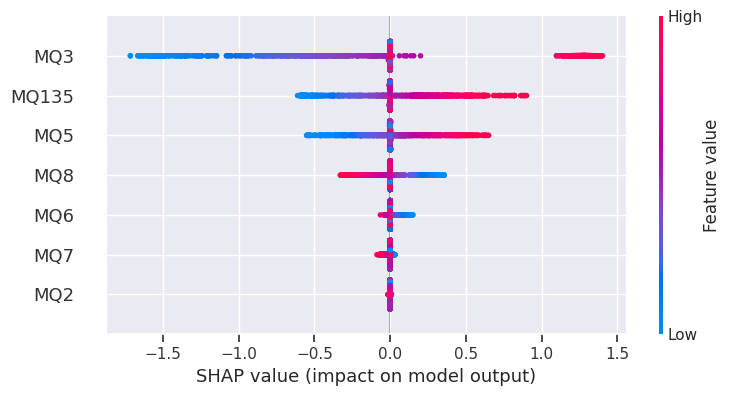

In [73]:
shap.summary_plot(shap_values_2D, x_test_2d)

In [58]:
len_test_set = X_test_2D.shape[0]
len_test_set

10092

_______ window 0 to 12 ___________


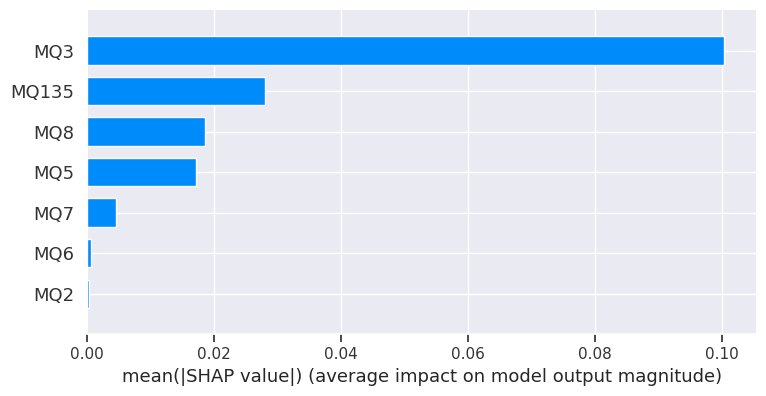

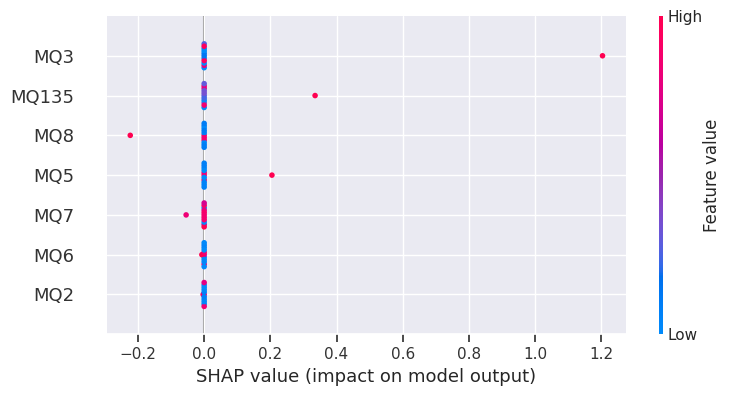



_______ window 1 to 13 ___________


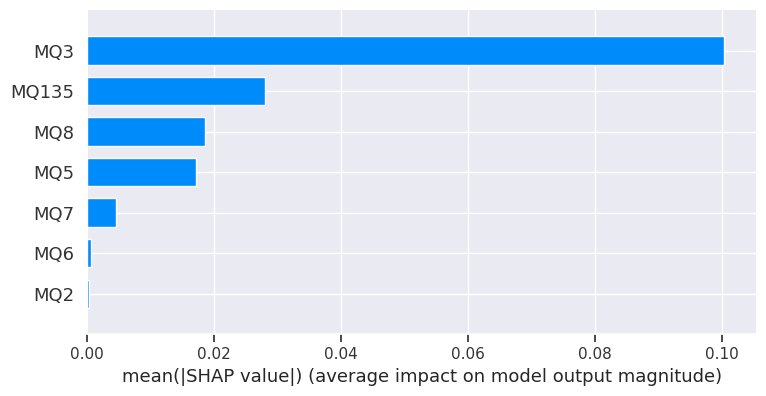

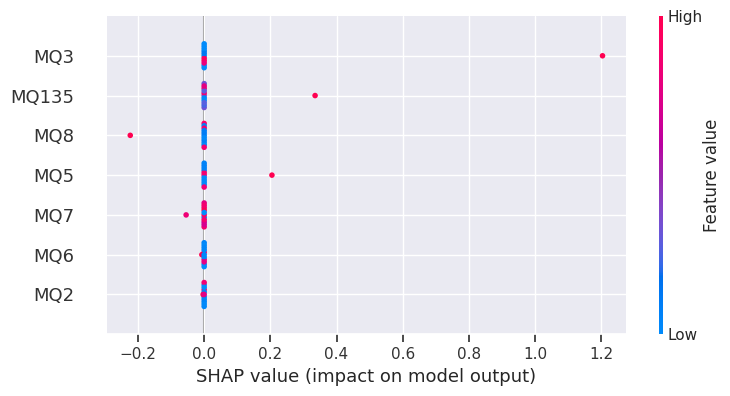



_______ window 2 to 14 ___________


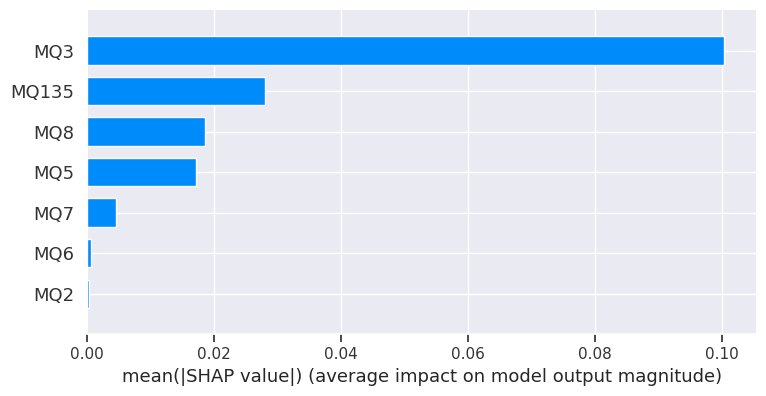

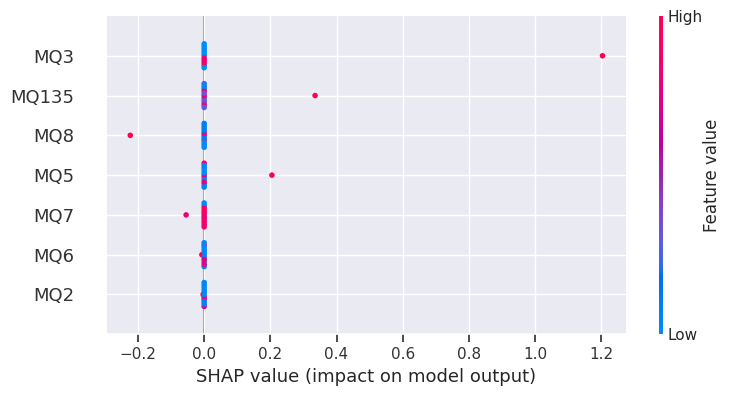



_______ window 3 to 15 ___________


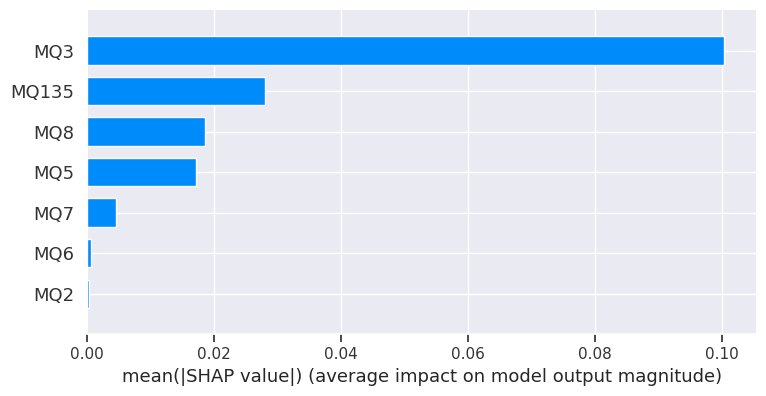

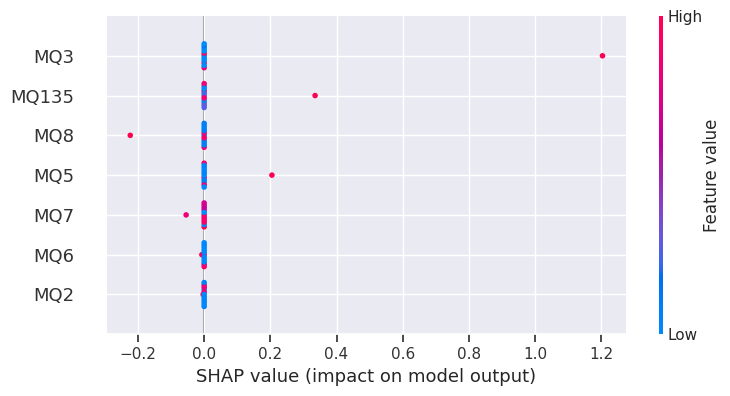



_______ window 4 to 16 ___________


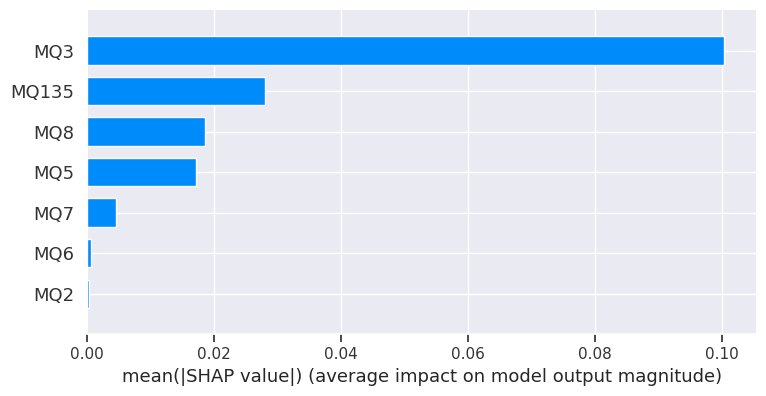

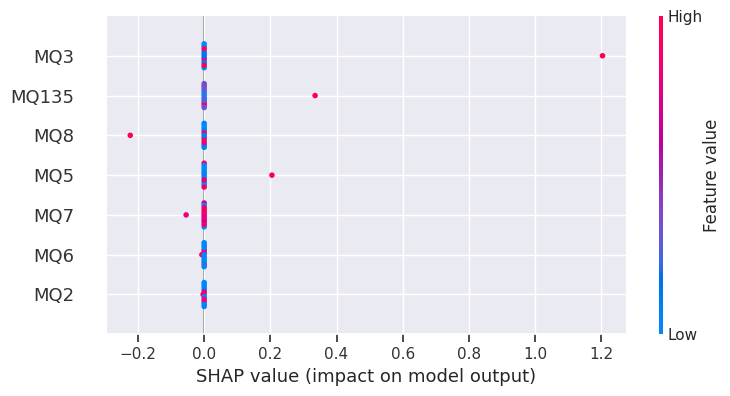



_______ window 5 to 17 ___________


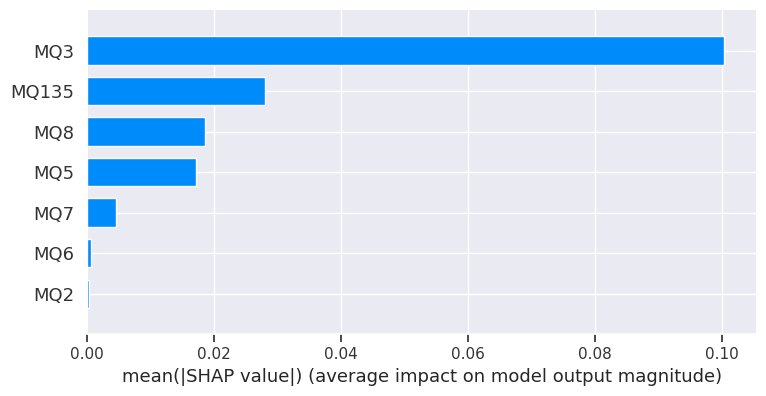

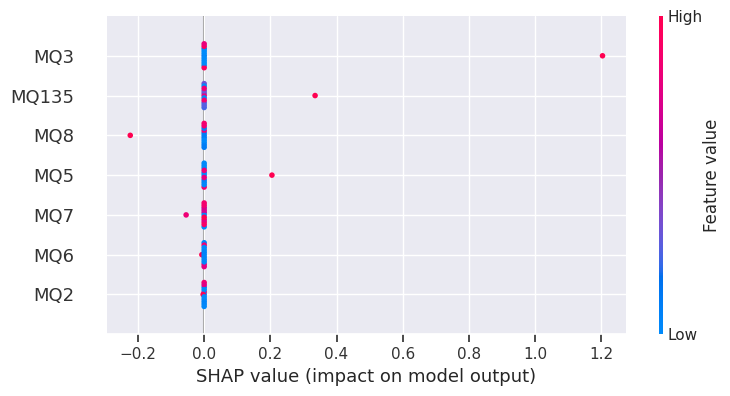



_______ window 6 to 18 ___________


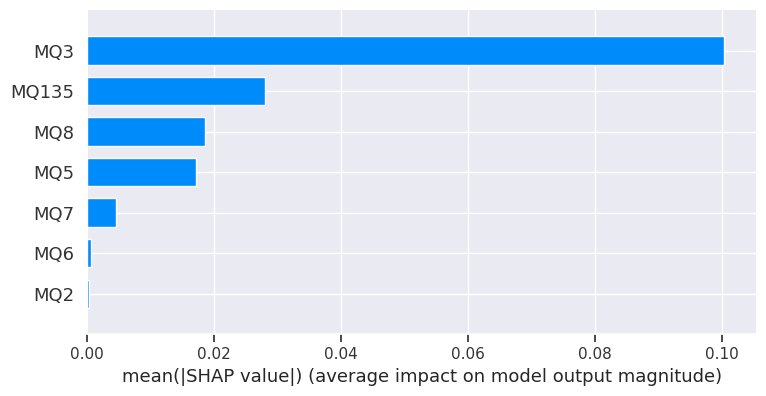

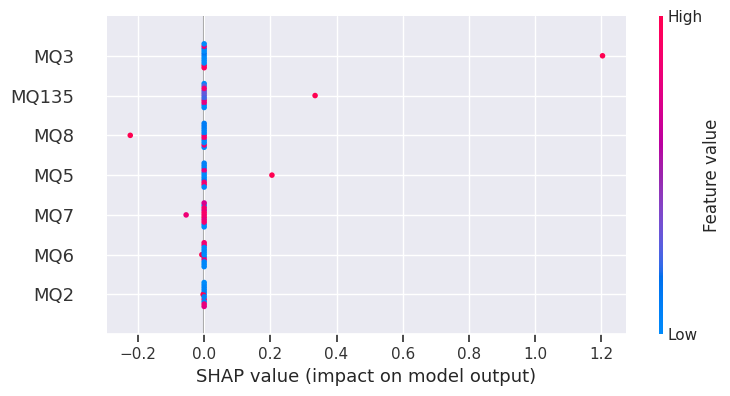



_______ window 7 to 19 ___________


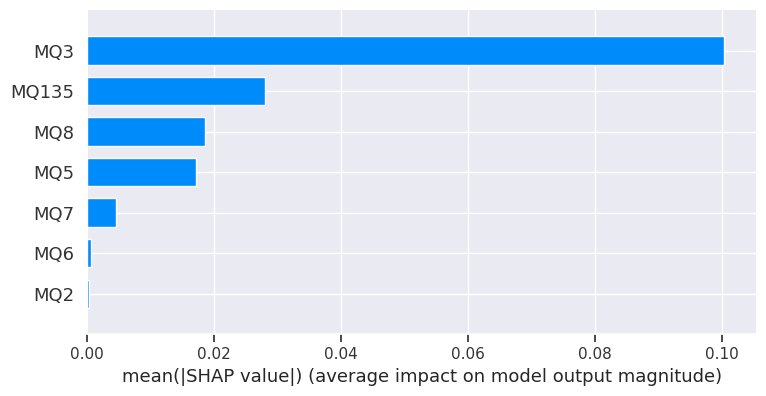

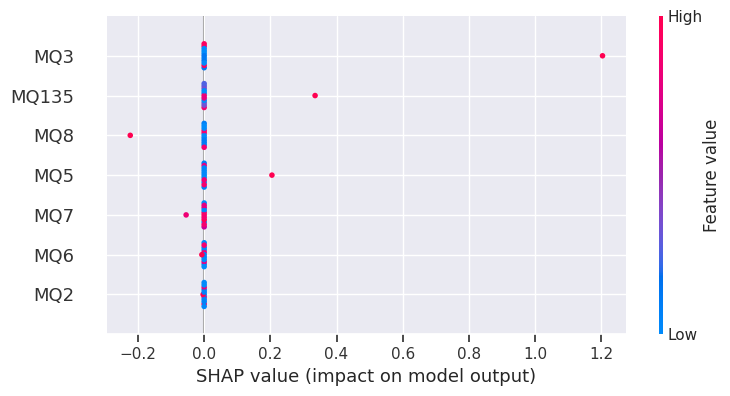



_______ window 8 to 20 ___________


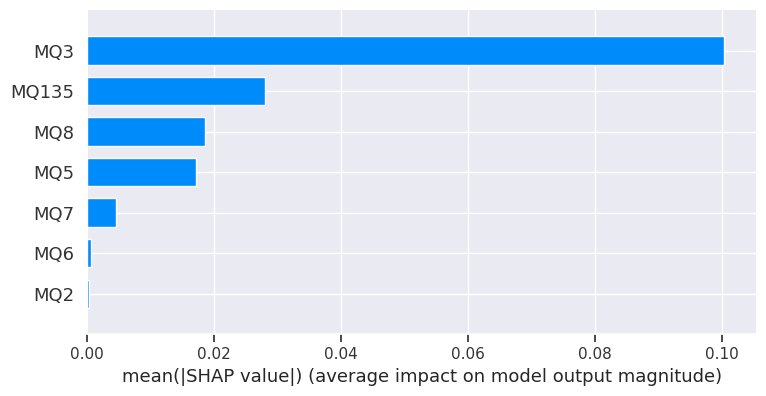

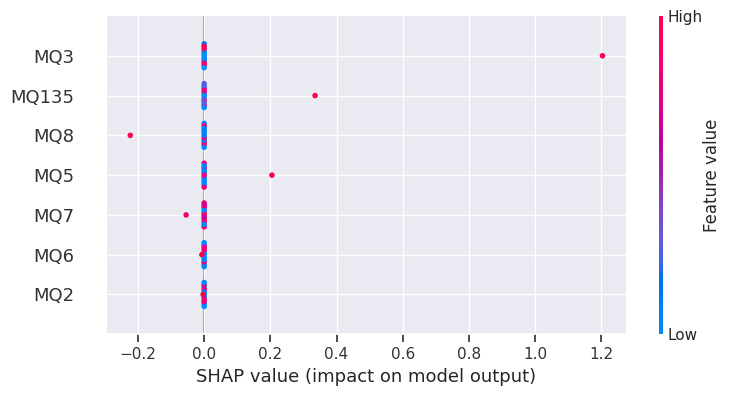

In [75]:
import shap

# Define the window size and step size
WINDOW_SIZE = 12
STEP_SIZE = 1

# Example lengths (should be defined based on your actual dataset)
len_test_set = 20

for start in range(0, len_test_set - WINDOW_SIZE + 1, STEP_SIZE):
    end = start + WINDOW_SIZE
    indice = list(range(start, end))
    
    shap_values_2D_window = shap_values_2D[indice]
    x_test_2d_window = x_test_2d.iloc[indice]
    
    print("_______ window {} to {} ___________".format(start, end))
    shap.summary_plot(shap_values_2D_window, x_test_2d_window, plot_type="bar")
    shap.summary_plot(shap_values_2D_window, x_test_2d_window)
    print("\n")


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (12,) and arg 2 with shape (12, 7, 7).

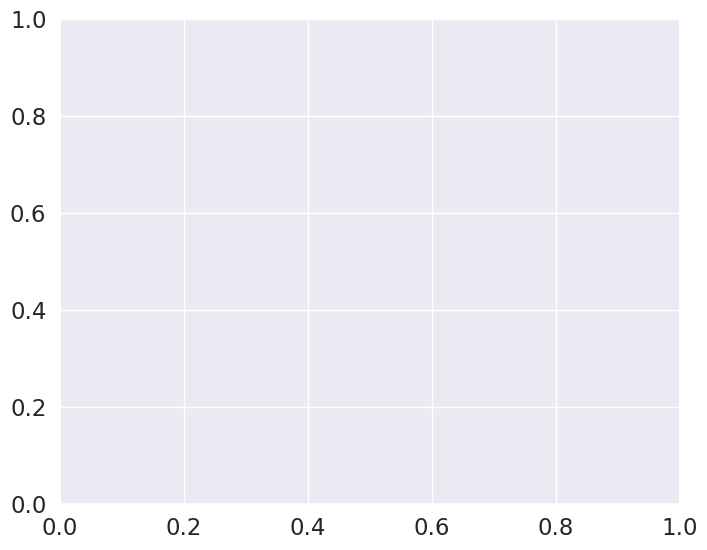

In [76]:
shap.initjs()
shap.summary_plot(shap_values, valid_sensor)

In [78]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_hook(self, module, input, output):
        self.activations = output

    def backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]
    
    def register_hooks(self):
        forward_handle = self.target_layer.register_forward_hook(self.forward_hook)
        backward_handle = self.target_layer.register_backward_hook(self.backward_hook)
        self.hook_handles.append(forward_handle)
        self.hook_handles.append(backward_handle)

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

    def __call__(self, input_image, class_idx=None):
        self.model.zero_grad()
        self.register_hooks()

        output, _ = self.model(input_image)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        
        score = output[:, class_idx]
        score.backward()

        gradients = self.gradients
        activations = self.activations

        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3, 4])
        activations = activations[0].cpu().data.numpy()
        for i in range(len(pooled_gradients)):
            activations[i, :, :, :] *= pooled_gradients[i].cpu().data.numpy()

        heatmap = np.mean(activations, axis=0)
        heatmap = np.maximum(heatmap, 0)
        heatmap = cv2.resize(heatmap, (input_image.shape[2], input_image.shape[3]))
        heatmap = heatmap - np.min(heatmap)
        heatmap = heatmap / np.max(heatmap)
        return heatmap


In [79]:
# Assuming `bagging_ensemble` is your trained BaggingEnsemble model
# and `image` is your input image tensor with shape (N, C, D, H, W)

# 获取每个子模型
for i, model in enumerate(bagging_ensemble.models):
    # 选择目标层，例如最后一个卷积层
    target_layer = model.vgg.features[-1]  # 假设使用modelA的最后一个卷积层

    # 创建GradCAM实例
    grad_cam = GradCAM(model, target_layer)

    # 计算Grad-CAM
    heatmap = grad_cam(image)

    # 可视化Grad-CAM
    plt.figure(figsize=(10, 10))
    plt.subplot(1, bagging_ensemble.num_models, i+1)
    plt.imshow(heatmap, cmap='viridis')
    plt.title(f'Model {i+1}')
    plt.axis('off')

plt.show()


In [ ]:
def overlay_heatmap(img, heatmap, alpha=0.6, colormap=cv2.COLORMAP_VIRIDIS):
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), colormap)
    overlay = heatmap * alpha + img * (1 - alpha)
    return overlay / overlay.max()

# 将 Grad-CAM 与原始图像叠加
for i, model in enumerate(bagging_ensemble.models):
    target_layer = model.modelA.features[-1]
    grad_cam = GradCAM(model, target_layer)
    heatmap = grad_cam(image)

    img = image[0].permute(1, 2, 3, 0).cpu().numpy()
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    overlay_img = overlay_heatmap(img, heatmap)

    plt.figure(figsize=(10, 10))
    plt.subplot(1, bagging_ensemble.num_models, i+1)
    plt.imshow(overlay_img)
    plt.title(f'Model {i+1}')
    plt.axis('off')

plt.show()
